
Project Name    :   Diabetic Retinopathy Detection

Description     :   

This project aims at detecting the presence of Diabetic Retinopathy. Diabetic Retinopathy is an eye disease
                    that damages the retina of the eyes due to diabetes. Retinal fundus Image is fed as input to the model,
                    and the model classifies it as either Non-Referable Diabetics Retinopathy(NRDR) or Referable Diabetics
                    Retinopathy(RDR)

File Description:   

This notebook consists of input pipeline, data balancing, data augmentation, model implementation, model prediction and model evaluation for Diabetic retinopathy binary classification problem

Contributors    :  Abirami Ravi (st164591)

In [80]:
from google.colab import drive
drive.mount ('/content/gdrive' )
root_path = '/content/gdrive/My Drive/Retinopathy'
print(root_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Retinopathy


In [0]:
!pip3 install --upgrade tensorflow
!pip3 install tensorflow-addons

In [0]:
import tensorflow as tf
import pathlib
import tensorflow.keras as k
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,MaxPooling2D, Input, Conv2D, LeakyReLU, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.mobilenet import preprocess_input 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Model
import cv2
from tensorflow.python.framework.ops import disable_eager_execution

Import the dataset from local machine

Defining the location of the dataset and extracting the count of the training and test images.

In [0]:
from google.colab import drive
drive.mount ('/content/gdrive' )
root_path = '/content/gdrive/My Drive/Retinopathy'
print(root_path)

In [4]:
train_directory = root_path + "/OriginalImages/TrainingSet"
test_directory = root_path + "/OriginalImages/TestingSet"

training_set_path = pathlib.Path(train_directory)
testing_set_path = pathlib.Path(test_directory)
training_labels = root_path + "/GroundTruths/IDRiD_Disease Grading_Training Labels.csv"
test_labels = root_path + "/GroundTruths/IDRiD_Disease Grading_Testing Labels.csv"

print(training_set_path)
print(testing_set_path)
train_image_count = len(list(training_set_path.glob("*.jpg")))
test_image_count = len(list(testing_set_path.glob("*.jpg")))
print("train images =",train_image_count)
print("test images =",test_image_count)

/content/gdrive/My Drive/Retinopathy/OriginalImages/TrainingSet
/content/gdrive/My Drive/Retinopathy/OriginalImages/TestingSet
train images = 413
test images = 103


Function Name       : decode_img

Function Description: Takes the content of the image input of any size and produces resized image of size 256*256

Arguments           : A Tensor of type String(content of img)

Returns             : Resized image of size 256*256

In [0]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [256, 256])



Function Name       : process_path

Function Description: Takes filepath and label as input and produces resized image along with label

Arguments           : image path and label

Returns             : image and label


In [0]:
def process_path(file_path,label):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


Function Name       : image_rotate

Function Description: Takes filepath and label as input and produces 90deg rotated and resized image along with label

Arguments           : image path and label

Returns             : image and label

In [0]:
def image_rotate(file_path,label):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    img = tfa.image.rotate(img,90)
    return img, label

Function Name       : adjust_contrast

Function Description: Takes image file path and label as input and produces images with contrast modified by a factor of 1.5 along with label

Arguments           : image path and label

Returns             : image and label

In [0]:
def adjust_contrast(file_path,label):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    img = tf.image.adjust_contrast(img, 1.5)
    return img, label

Function Name       : horizontal_flipped_images

Function Description: Takes image file path and label as input and produces horizontally flipped images

Arguments           : image path and label

Returns             : image and label

In [0]:
def horizontal_flipped_images(file_path, label):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    img = tf.image.random_flip_left_right(img)
    return img, label

Function Name : vertical_flipped_images

Function Description: Takes image file path and label as input and produces vertically flipped images

Arguments : image path and label

Returns : image and label

In [0]:
def vertical_flipped_images(file_path, label):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    img = tf.image.random_flip_up_down(img)
    return img, label

Function Name : adjust_brightness

Function Description: Takes image file path and label as input and produces brighter image

Arguments : image path and label

Returns : image and label

In [0]:
def adjust_brightness(file_path, label):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    img = tf.image.adjust_brightness(img,1.5)
    return img, label


Function Name       :   referable_set

Function Description:   This function is same as that of read_label_file but it extracts image paths for which the label value is '1'

Arguments           :   image path and label file

Returns             :   list of image paths and labels


In [0]:
def referable_set(filepath,directory,startpoint,endpoint):
  images_list = []
  labels_list = []
  count = 0;
  with open(filepath) as labels:
    for line_no,line in enumerate(labels):
      if line_no > endpoint:
        break
      if (line_no >= startpoint) and (line_no <= endpoint):
        #print(line_no,line)
        x = line.split(',')
        #print(type(x),x)
        if float(x[1]) > 1 :
          labels_list.append(1)
          path = directory + "/"+x[0]+".jpg"
          images_list.append(path)
          count = count + 1
  #print(images_list,"\n")
  #print(labels_list)
  #print(count)
  return images_list,np.array(labels_list, dtype=np.float32)           



Function Name       :   non_referable_set

Function Description:   This function is same as that of read_label_file but it extracts image paths for which the label value is '0'

Arguments           : image path and label file

Returns             : list of image paths and labels


In [0]:
def non_referable_set(filepath,directory,startpoint,endpoint):
  images_list = []
  labels_list = []
  count = 0;
  with open(filepath) as labels:
    for line_no,line in enumerate(labels):
      if line_no > endpoint:
        break
      if (line_no >= startpoint) and (line_no <= endpoint):
        #print(line_no,line)
        x = line.split(',')
        #print(type(x),x)
        if float(x[1]) <= 1 :
          labels_list.append(0)
          path = directory + "/"+x[0]+".jpg"
          images_list.append(path)
          count = count + 1
  #print(images_list,"\n")
  #print(labels_list)
  #print(count)
  return images_list,np.array(labels_list, dtype=np.float32)  

First of all validation dataset is created with equal number of referable set and non-referable set. 

Validation dataset of size 100 with NRDR : 50 and RDR: 50 is created

In [0]:
valid_images_NR,valid_labels_NR = non_referable_set(training_labels,train_directory,1,193)
#print(valid_images_NR, valid_labels_NR)
#print("Total valid NR images:",len(valid_images_NR))

In [0]:
valid_images_R, valid_labels_R = referable_set(training_labels,train_directory, 1,51)
#print(valid_images_R, valid_labels_R)
#print("Total valid R images:",len(valid_images_R))

In [0]:
valid_images = valid_images_NR + valid_images_R
valid_labels = np.hstack((valid_labels_NR, valid_labels_R))
#print(valid_labels)
#print("Total valid images:",len(valid_images))
validation_ds = tf.data.Dataset.from_tensor_slices((valid_images,valid_labels))

validation_ds = validation_ds.map(process_path, num_parallel_calls=None)
validation_ds = validation_ds.shuffle(100).batch(10)
#for elem in validation_ds:
  #print(elem)

Training dataset is created with the remaining elements in the dataset that are present after the creation of validation dataset.

Training dataset:

 *NRDR: 104*

*RDR: 209*

Total: 313

In [0]:
train_images_NR, train_labels_NR = non_referable_set(training_labels,train_directory,194,413)
print(train_images_NR, train_labels_NR)
print("NR training images:", len(train_images_NR))

In [0]:
train_images_R, train_labels_R = referable_set(training_labels,train_directory, 52,413)
print(train_images_R, train_labels_R)
print("R training images:", len(train_images_R))

In [0]:
train_images = train_images_NR + train_images_R
train_labels = np.hstack((train_labels_NR, train_labels_R))
print(train_labels)
print("Total training images:",len(train_images))

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images,train_labels))
train_ds = train_ds.shuffle(313)
print(train_ds)
'''for elem in train_ds:
  print(elem)'''
train_ds = train_ds.map(process_path, num_parallel_calls=None)
#for elem in train_ds:
  #print(elem)

## Data Augmentation:
The remaining images in the training dataset are augmented and resampling is done in order to produce a balanced dataset. The existing training dataset consists of 104 - NRDR and 209 - RDR.In total there are 313 items in the dataset.


## Data balancing using data augmentation:
1. Adjust contrast : 104 - NRDR and 209 - RDR
2. Image rotation: 104 - NRDR and 209 RDR
3. Vertical flipping: 104 - NRDR and 0 - RDR
4. Horizontal flipping: 104 - NRDR and 0 - RDR
5. Adjust Brightness: 104 - NRDR and 0 - RDR

### Note:
As the no of RDR is large compared to no of NRDR, flipping and adjust brightness data augmentation techniques is applied only to RDR data items

After data augmentation the training dataset contains 624 - NRDR and 627 - RDR. Therefore the dataset is balanced with 1251 elements in total.



In [0]:
train_img_contrast = train_images
train_label_contrast = train_labels
train_contrast_ds = tf.data.Dataset.from_tensor_slices((train_img_contrast,train_label_contrast))
train_contrast_ds = train_contrast_ds.map(adjust_contrast, num_parallel_calls=None)
combined_training_ds= train_ds.concatenate(train_contrast_ds)
count = 0
#for elem in combined_training_ds:
  #count = count+1;
#print(count)

In [0]:
#Rotation of images
train_img_rotate = train_images
train_label_rotate = train_labels
train_rotate_ds = tf.data.Dataset.from_tensor_slices((train_img_rotate,train_label_rotate))
train_rotate_ds = train_rotate_ds.map(image_rotate, num_parallel_calls=None)
combined_training_ds1= combined_training_ds.concatenate(train_rotate_ds)


In [0]:
#Horizontal flipping and vertical flipping of images of type NR
flip_images = train_images_NR
flip_labels = train_labels_NR
print("Total images to be flipped:",len(flip_images))
print(flip_images)

In [0]:
train_hflipped_ds = tf.data.Dataset.from_tensor_slices((flip_images,flip_labels))
train_hflipped_ds = train_hflipped_ds.shuffle(104)
train_hflipped_ds = train_hflipped_ds.map(horizontal_flipped_images, num_parallel_calls=None)
combined_training_ds2= combined_training_ds1.concatenate(train_hflipped_ds)
count1 = 0
'''for elem in combined_training_ds1:
  count1 = count1+1
print(count1)'''

In [0]:
#Vertical flipping of images
train_vflipped_ds = tf.data.Dataset.from_tensor_slices((flip_images,flip_labels))
train_vflipped_ds = train_vflipped_ds.shuffle(104)
train_vflipped_ds = train_vflipped_ds.map(vertical_flipped_images, num_parallel_calls=None)
combined_training_ds3= combined_training_ds2.concatenate(train_vflipped_ds)
count1 = 0
#for elem in combined_training_ds3:
  #count1 = count1+1
#print(count1)

In [22]:
#adjust brightness
train_brightness_ds = tf.data.Dataset.from_tensor_slices((flip_images,flip_labels))
train_brightness_ds = train_brightness_ds.shuffle(104)
train_brightness_ds = train_brightness_ds.map(adjust_brightness, num_parallel_calls=None)
combined_training_ds4= combined_training_ds3.concatenate(train_brightness_ds)
count1 = 0
for elem in combined_training_ds4:
  count1 = count1+1
print(count1)

1251


In [0]:
train_ds = combined_training_ds4.shuffle(1251).batch(10)


### Test Dataset Creation

In [0]:
#test dataset creation
test_images_NR, test_labels_NR = non_referable_set(test_labels,test_directory,1,103)
test_images_R, test_labels_R = referable_set(test_labels,test_directory,1,103)


In [0]:
test_images = test_images_NR + test_images_R
test_labels = np.hstack((test_labels_NR, test_labels_R))
print(test_labels)
print("Total test images:",len(test_images))

In [0]:
test_ds = tf.data.Dataset.from_tensor_slices((test_images,test_labels))
test_ds = test_ds.map(process_path, num_parallel_calls=None)
test_ds = test_ds.shuffle(103).batch(10)

### Model Architecture


In [38]:
batch_size = 100
epochs = 150
learning_rate = 0.0001

inputs = k.layers.Input(shape=(256,256,3))

conv_layer1 = Conv2D(4,3,(1,1))(inputs)
print(conv_layer1)
MP_layer1 = MaxPooling2D((3,3))(conv_layer1)
BN_layer1 = BatchNormalization()(MP_layer1)

# a layer instance is callable on a tensor, and returns a tensor
conv_layer2 = Conv2D(8,3,(2,2))(BN_layer1)
MP_layer2 = MaxPooling2D((3,3))(conv_layer2)
BN_layer2 = BatchNormalization()(MP_layer2)

conv_layer3 = Conv2D(16,3)(BN_layer2)
MP_layer3 = MaxPooling2D((3,3))(conv_layer3)
BN_layer3 = BatchNormalization()(MP_layer3)

GAP = k.layers.GlobalAveragePooling2D()(BN_layer3)

flatten = k.layers.Flatten()(GAP)
dense_layer1 = Dense(4)(flatten)

output = k.layers.Dense(1, activation='sigmoid')(dense_layer1)
model = k.models.Model(inputs=inputs, outputs=output)
opt = k.optimizers.RMSprop(learning_rate)
model.compile(optimizer='Adam' ,loss="binary_crossentropy", metrics= ['accuracy'])
model.summary()
#model = Model(inputs=inputs, outputs=output)

Tensor("conv2d_21/Identity:0", shape=(None, 254, 254, 4), dtype=float32)
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 254, 254, 4)       112       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 84, 84, 4)         0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 84, 84, 4)         16        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 41, 41, 8)         296       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 8)         0         
____________________________________________________

## Model Training

In [0]:
filepath="/Feb09binary-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint_path = root_path + filepath

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=False)
callbacks_list = [checkpoint]

model.fit(train_ds,validation_data=validation_ds, epochs = 150, callbacks=[checkpoint])

## Model Performance Visualization

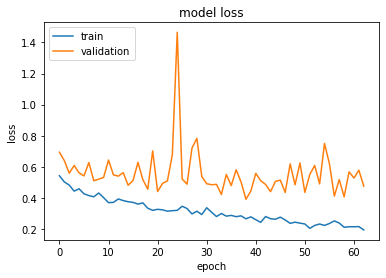

In [41]:
# summarize history for training loss and validation loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

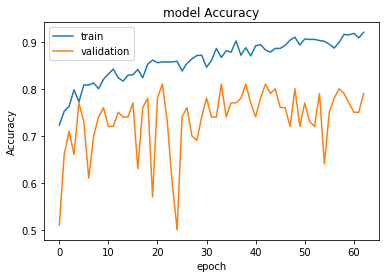

In [43]:
# summarize history for training accuracy and validation accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Model Prediction

In [0]:
prediction = []
result = model.predict(test_ds)
for x in result:
  prediction.append(int(tf.round(x)))

## Model Evaluation

Model is evaluated based on the following metrics:
1. Confusion Matrix
2. Precision
3. Recall
4. F1 score

In [87]:
ground_truth = []
for features, label in test_ds:
  for y in label:
    ground_truth.append(int(y))
confusion = tf.math.confusion_matrix(
    ground_truth,
    prediction,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
print("Confusion matrix:",confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

precision = float(TP / (TP + FP))
print("Precision:",precision)

recall = float(TP/(TP+FN))
print("Recall:",recall)

f1_score = 2 * (((precision*recall)/(precision+recall)))
print("F1 score:",f1_score)

Confusion matrix: tf.Tensor(
[[14 25]
 [16 48]], shape=(2, 2), dtype=int32)
Precision: 0.6575342465753424
Recall: 0.75
F1 score: 0.7007299270072993
